Peut-on se fier aux prévisions de températures de météo-France ? 

Ce projet est dédié à l'analyse des erreurs de prévisions de températures de météo France. Tout d'abord nous allons décrire les erreurs de prévsisions de températures, puis essayer de comprendre via d'atures variables météorologiques ces errerus et les sources de ces erreurs, enfn nous allons essayer de faire des prédictions sur les températures prédites par météo france pour essayer d'approcher au mieux les températures réelles.   

Préliminaires : récupérations des données et préparations des data frame :

Obtention des données via le site open-meteo.com, nous allons nous concentrer dans un premier temps sur les températures prédites, et relevées en France sur l'année 2023.  

In [1]:
#importation de toutes les libraries et téléchargement des libraries peut courantes

!pip install openmeteo_requests
!pip install requests_cache
!pip install retry_requests
!pip install s3fs

import openmeteo_requests
import numpy as np
import requests_cache
from retry_requests import retry
import requests
import time 
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gpd
from scipy.stats import pearsonr
import seaborn as sns
from shapely.geometry import Point
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

Deux méthodes d'analyses vont être effectuées, l'une selectionne un échantillon aléatoire de point en France métropolitaine et analyse à partir de ces points les erreurs de prévisions. La deuxième se base sur la localisation des communes de France qui constitue des endroits d'office assez interressant. 

Pour la deuxième méthode nous utilisons le fichier des communes de France établi par l'INSEE, ce fichier associe chaque commune à une longitude, une latitude, un département, une région et un nom. Nous allons seulement utiliser les coordonnées de chaque communes. Cependant il y a plus de 38000 communes en france, 365 jours pour l'année 2023 et 24h par jour, ce qui fait 332880000 lignes dans un data frame, ce qui pour mon ordinateur en tout cas n'a pas été en mesure de traier. ainsi nous allons nous concentrer sur 2719 communes, non prises aléatoirement dans l'échantillon car le fichier est trié par ordre alphabétique des communes, en prenant 2719 communes consécutives nous nous assurons ainsi une certaine proximité entre communes se qui pousse à croire en une meilleure robustesse des résultats, puisque ces derniers seront moins sujets à des variations de localisations. 

In [ ]:
ETUDE PAR LES COMMUNES DE FRANCE    

In [2]:
commune_de_france=requests.get('https://www.data.gouv.fr/fr/datasets/r/dbe8a621-a9c4-4bc3-9cae-be1699c5ff25')
with open("communes_de_france.csv", "wb") as f:
    f.write(commune_de_france.content)

communes_de_france = pd.read_csv('communes_de_france.csv')
communes_de_france["latitude"].dropna(inplace=True)
communes_de_france["longitude"].dropna(inplace=True)

extrait_communes_de_france = communes_de_france.iloc[30001:32719] 


Téléchargement via l'API d'open-meteo des températures prédites en 2023 par heure pour les 2719 communes de France séléctionnées plus haut (Ne pas lancer extremement long, des exemples de requetes courtes seront données plus bas)

In [3]:
#data_frame_storage_past_forecast=pd.DataFrame(columns=['date','temperature_2m', 'latitude', "longitude"])
		# Setup the Open-Meteo API client with cache and retry on error
"""for i in range(len(extrait_communes_de_france)):
				cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
				retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
				openmeteo = openmeteo_requests.Client(session = retry_session)

				# Make sure all required weather variables are listed here
				# The order of variables in hourly or daily is important to assign them correctly below
				url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
				params = {
					"latitude": extrait_communes_de_france["latitude"].iloc[i],
					"longitude": extrait_communes_de_france["longitude"].iloc[i],
					"start_date": "2023-01-01",
					"end_date": "2023-12-31",
					"hourly": "temperature_2m",
					"models": "meteofrance_seamless"
				}
				responses = openmeteo.weather_api(url, params=params)
								# Process first location. Add a for-loop for multiple locations or weather models
				response = responses[0]
				# Process hourly data. The order of variables needs to be the same as requested.
				hourly = response.Hourly()
				hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

				hourly_data = {"date": pd.date_range(
					start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
					end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
					freq = pd.Timedelta(seconds = hourly.Interval()),
					inclusive = "left"
				)}
				hourly_data["temperature_2m"] = hourly_temperature_2m


				hourly_dataframe = pd.DataFrame(data = hourly_data)
				hourly_dataframe.dropna(inplace=True)
				hourly_dataframe["latitude"] = [extrait_communes_de_france["latitude"].iloc[i] for k in range(len(hourly_dataframe))]
				hourly_dataframe["longitude"] = [extrait_communes_de_france["longitude"].iloc[i] for k in range(len(hourly_dataframe))]
				data_frame_storage_past_forecast = pd.concat([data_frame_storage_past_forecast, hourly_dataframe], axis=0)
				time.sleep(0.5)
				print(i)
                
nom='température4_predites.csv'
data_frame_storage_past_forecast.to_csv(nom)
"""



'for i in range(len(extrait_communes_de_france)):\n\t\t\t\tcache_session = requests_cache.CachedSession(\'.cache\', expire_after = 3600)\n\t\t\t\tretry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)\n\t\t\t\topenmeteo = openmeteo_requests.Client(session = retry_session)\n\n\t\t\t\t# Make sure all required weather variables are listed here\n\t\t\t\t# The order of variables in hourly or daily is important to assign them correctly below\n\t\t\t\turl = "https://historical-forecast-api.open-meteo.com/v1/forecast"\n\t\t\t\tparams = {\n\t\t\t\t\t"latitude": extrait_communes_de_france["latitude"].iloc[i],\n\t\t\t\t\t"longitude": extrait_communes_de_france["longitude"].iloc[i],\n\t\t\t\t\t"start_date": "2023-01-01",\n\t\t\t\t\t"end_date": "2023-12-31",\n\t\t\t\t\t"hourly": "temperature_2m",\n\t\t\t\t\t"models": "meteofrance_seamless"\n\t\t\t\t}\n\t\t\t\tresponses = openmeteo.weather_api(url, params=params)\n\t\t\t\t\t\t\t\t# Process first location. Add a for-loop for multiple

Téléchargement des températures effectivement relevées en 2023 par heure pour les même communes de France

In [4]:
"""data_frame_storage_past_forecast=pd.DataFrame(columns=['date','temperature_2m', 'latitude', "longitude"])
# Setup the Open-Meteo API client with cache and retry on error
for i in range(len(extrait_communes_de_france)):
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
			"latitude": extrait_communes_de_france["latitude"].iloc[i],
			"longitude": extrait_communes_de_france["longitude"].iloc[i],
			"start_date": "2023-01-01",
			"end_date": "2023-12-31",
			"hourly": "temperature_2m"
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m

    hourly_dataframe = pd.DataFrame(data = hourly_data)
    hourly_dataframe.dropna(inplace=True)
    hourly_dataframe["latitude"] = [extrait_communes_de_france["latitude"].iloc[i] for k in range(len(hourly_dataframe))]
    hourly_dataframe["longitude"] = [extrait_communes_de_france["longitude"].iloc[i] for k in range(len(hourly_dataframe))]
    data_frame_storage_past_forecast = pd.concat([data_frame_storage_past_forecast, hourly_dataframe], axis=0)
    time.sleep(0.5)
    print(i)
    
nom='température4_reelles.csv'
data_frame_storage_past_forecast.to_csv(nom)"""




'data_frame_storage_past_forecast=pd.DataFrame(columns=[\'date\',\'temperature_2m\', \'latitude\', "longitude"])\n# Setup the Open-Meteo API client with cache and retry on error\nfor i in range(len(extrait_communes_de_france)):\n    cache_session = requests_cache.CachedSession(\'.cache\', expire_after = -1)\n    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)\n    openmeteo = openmeteo_requests.Client(session = retry_session)\n\n    # Make sure all required weather variables are listed here\n    # The order of variables in hourly or daily is important to assign them correctly below\n    url = "https://archive-api.open-meteo.com/v1/archive"\n    params = {\n\t\t\t"latitude": extrait_communes_de_france["latitude"].iloc[i],\n\t\t\t"longitude": extrait_communes_de_france["longitude"].iloc[i],\n\t\t\t"start_date": "2023-01-01",\n\t\t\t"end_date": "2023-12-31",\n\t\t\t"hourly": "temperature_2m"\n    }\n    responses = openmeteo.weather_api(url, params=params)\n\n    #

Petite précisions concernant les températures prédites : il s'agit des températures prédites à h-3 au point considéré. Ainsi la prédiction est effectuée 3h avant, ce qui est sensé assuré une meilleure précision des prédictions.

Préparation du fichier contenant les températures (le fichier final est sur le ssp cloud )

In [5]:
"""communes_de_france_temp_reelle4 = pd.read_csv('température4_reelles.csv')
communes_de_france_temp_predite4 = pd.read_csv('température4_predites.csv')"""

"communes_de_france_temp_reelle4 = pd.read_csv('température4_reelles.csv')\ncommunes_de_france_temp_predite4 = pd.read_csv('température4_predites.csv')"

In [6]:
"""communes_de_france_temp_reelle4 = communes_de_france_temp_reelle4.rename(columns={communes_de_france_temp_reelle4.columns[0]: 'compteur'})


température4_merged = pd.merge(communes_de_france_temp_predite4,communes_de_france_temp_reelle4, on=['date', 'longitude', 'latitude'])

new_name1 = {'temperature_2m_x' :  'temperature_2m', 'temperature_2m_y' : 'temperature_reelle_2m'}
température=température4_merged.rename(columns=new_name1)

print(température)"""


"communes_de_france_temp_reelle4 = communes_de_france_temp_reelle4.rename(columns={communes_de_france_temp_reelle4.columns[0]: 'compteur'})\n\n\ntempérature4_merged = pd.merge(communes_de_france_temp_predite4,communes_de_france_temp_reelle4, on=['date', 'longitude', 'latitude'])\n\nnew_name1 = {'temperature_2m_x' :  'temperature_2m', 'temperature_2m_y' : 'temperature_reelle_2m'}\ntempérature=température4_merged.rename(columns=new_name1)\n\nprint(température)"

In [7]:
"""température.to_csv('température4')"""

"température.to_csv('température4')"

Télécharge le fichier depuis le SSP cloud (fichier assez volumineux, 2.6Go prend environ 6m)

In [59]:
FILE_PATH_S3 = "https://minio.lab.sspcloud.fr/sim2023/projet_python_data_science/température4.csv"
température4=requests.get(FILE_PATH_S3)
with open("température4.csv", "wb") as f:
    f.write(température4.content)

température = pd.read_csv('température4.csv')



Finalisation du data frame : on renomme les colonnes pour éviter les confusions : temperature_2m correspond à la température (en degré Celsius) à 2m du sol prédite par météo france, tandis que temperature_2m_reelle correspond à la température effectivement relevée à 2m du sol. Les données sont ici présentées heure par heure. On ajoute les colonnes d'erreur de prévisions : la colonne erreur peut-être posisitive ou négative, tandis que l'erreur absolue est la valeur absolue de l'erreur, justifions immédiatement l'usage de cette deuxième erreur.

In [60]:
new_name1 = {'temperature_2m_x' :  'temperature_2m', 'temperature_2m_y' : 'temperature_reelle_2m'}
température=température.rename(columns=new_name1)


In [61]:
#ajout des colonnes erreur et erreur absolue. Cette dernière est importante car le modèle se trompe presque autant en positif qu'en négatif, ainsi la moyenne de l'erreur est presque nuelle, ce qui ne nous renseigne pas beaucoup 
#environ 2m à executer

température["error"]=température["temperature_2m"]-température["temperature_reelle_2m"]
température["absolute_error"]=abs(température["error"])
température['date'] = pd.to_datetime(température['date']) # pour pouvoir facilement selectionner la date 
température = température.drop('Unnamed: 0', axis=1) 
température = température.drop('Unnamed: 0.1', axis=1) 
température

,date,temperature_2m,latitude,longitude,compteur,temperature_reelle_2m,error,absolute_error
0,2023-01-01 00:00:00+00:00,10.7935,47.620239,7.300485,0,8.688001,2.105499,2.105499
1,2023-01-01 01:00:00+00:00,10.5435,47.620239,7.300485,1,9.338000,1.205500,1.205500
2,2023-01-01 02:00:00+00:00,10.0435,47.620239,7.300485,2,9.088000,0.955500,0.955500
3,2023-01-01 03:00:00+00:00,9.2935,47.620239,7.300485,3,11.138001,-1.844501,1.844501
4,2023-01-01 04:00:00+00:00,9.6935,47.620239,7.300485,4,11.988000,-2.294500,2.294500
...,...,...,...,...,...,...,...,...
30012135,2023-12-31 19:00:00+00:00,7.2150,49.536044,1.274291,8755,6.643500,0.571500,0.571500
30012136,2023-12-31 20:00:00+00:00,6.9650,49.536044,1.274291,8756,6.443500,0.521500,0.521500
30012137,2023-12-31 21:00:00+00:00,6.6150,49.536044,1.274291,8757,6.293500,0.321500,0.321500
30012138,2023-12-31 22:00:00+00:00,6.5150,49.536044,1.274291,8758,6.293500,0.221500,0.221500


Le Data frame final, appelé température contient donc la position de chaque commune de l'échantillon (latitude et longitude), l'heure associée à la prédiction et au relevé de température, l'erreur de prévision et l'erreur absolue. 

I) Statistiques descriptives 

In [62]:
température.describe()

,temperature_2m,latitude,longitude,compteur,temperature_reelle_2m,error,absolute_error
count,3.001214e+07,3.001214e+07,3.001214e+07,3.001214e+07,3.001214e+07,3.001214e+07,3.001214e+07
mean,1.178816e+01,4.677136e+01,4.774628e+00,4.377007e+03,1.153931e+01,2.488530e-01,1.223032e+00
std,8.239208e+00,1.044374e+00,2.078478e+00,2.527363e+03,8.286451e+00,1.680122e+00,1.178530e+00
min,-2.455100e+01,4.512337e+01,-4.115236e-01,0.000000e+00,-2.775550e+01,-1.524900e+01,0.000000e+00
25%,5.817500e+00,4.587460e+01,4.475200e+00,2.188000e+03,5.717500e+00,-6.470001e-01,4.070020e-01
50%,1.125650e+01,4.652006e+01,5.513290e+00,4.377000e+03,1.111600e+01,2.330000e-01,8.940010e-01
75%,1.753250e+01,4.765055e+01,6.248441e+00,6.566000e+03,1.753250e+01,1.097000e+00,1.660001e+00
max,4.224550e+01,4.998521e+01,7.584537e+00,8.759000e+03,4.221800e+01,1.743900e+01,1.743900e+01


Ainsi on remarque que la moyenne d'erreur sur l'échantillon de communes selectionnées est proche de 0 : en effet on s'attend à ce que le modèle se trompe autant en positif qu'en négatif, alors que l'écart absolue est en moyenne de 1.22°C.
le modèle s'est au maximum trompé de 17,44°C ! 
Tracons pour mieux visualiser la répartitions des erreurs du modèle.

C:\Users\tsang\AppData\Local\Temp\ipykernel_10716\1642820630.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(température['error'])


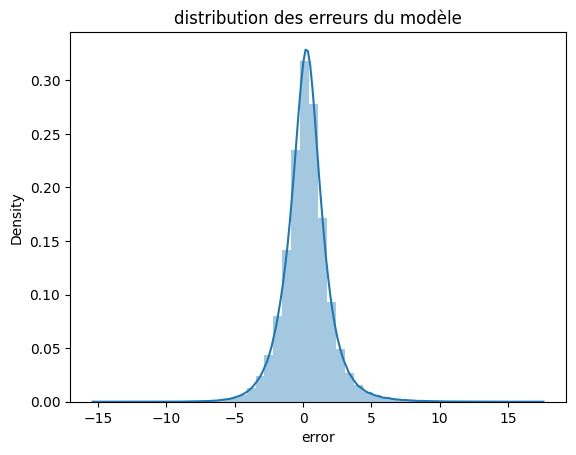

In [63]:
#environ 1m30s à executer

plt.figure()
sns.distplot(température['error'])
plt.title("distribution des erreurs du modèle")
plt.show()

On observe  ce qui ressemble à une belle Gaussienne (presque centrée) dans la distribution des erreurs du modèle. Cependant, le nombre d'erreurs assez importantes est assez conséquent. Etudions la répartion des erreurs dites inacceptable (celle dont l'erreur est supérieur à 10°C, un tel écart pourrait nous faire prendre froid assez facilement par exemple ! d'où l'inacceptabilité de l'erreur)

In [64]:
température['date'] = pd.to_datetime(température['date']) # pour pouvoir facilement selectionner la date 

In [65]:
important_error=température[température["absolute_error"]>=10] # on regarde où et quand ont eu lieu les ecarts de prévisions importants ie supérieurs à 7°C 

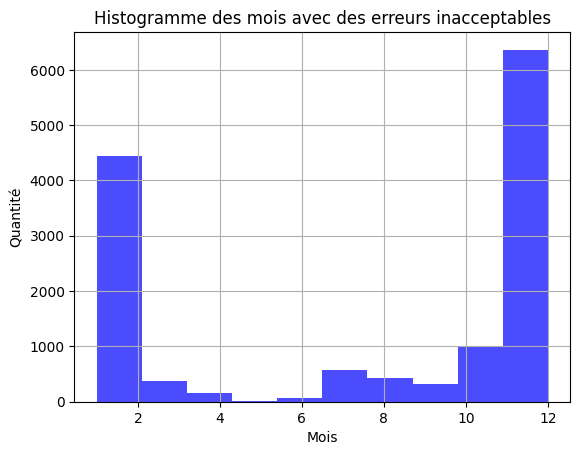

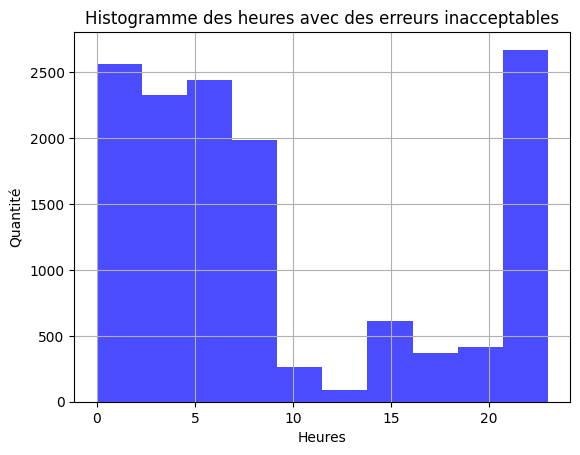

In [45]:
plt.hist(important_error["date"].dt.month, alpha=0.7, color='b')

plt.xlabel('Mois')
plt.ylabel('Quantité')
plt.title('Histogramme des mois avec des erreurs inacceptables')
plt.grid(True)


plt.show()


plt.hist(important_error["date"].dt.hour, alpha=0.7, color='b')

# Customize the plot
plt.xlabel('Heures')
plt.ylabel('Quantité')
plt.title('Histogramme des heures avec des erreurs inacceptables')
plt.grid(True)


plt.show()

On remarque que le modèle semble se tromper particulièrement en hiver, fin automne et début printemps, avec un nombre d'erreur minimal en mai. Et principalement durant la nuit. Ici on ne concidère que le nombre d'erreur inacceptable.

Regardons maintenant quelles sont les communes de l'échantillon, cela nous premettra peut-être de mieux comprendre d'où proviennent ces erreurs.

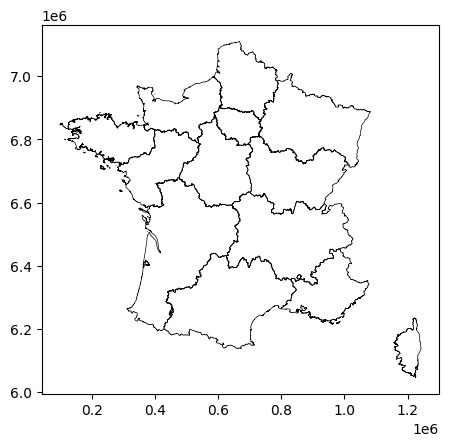

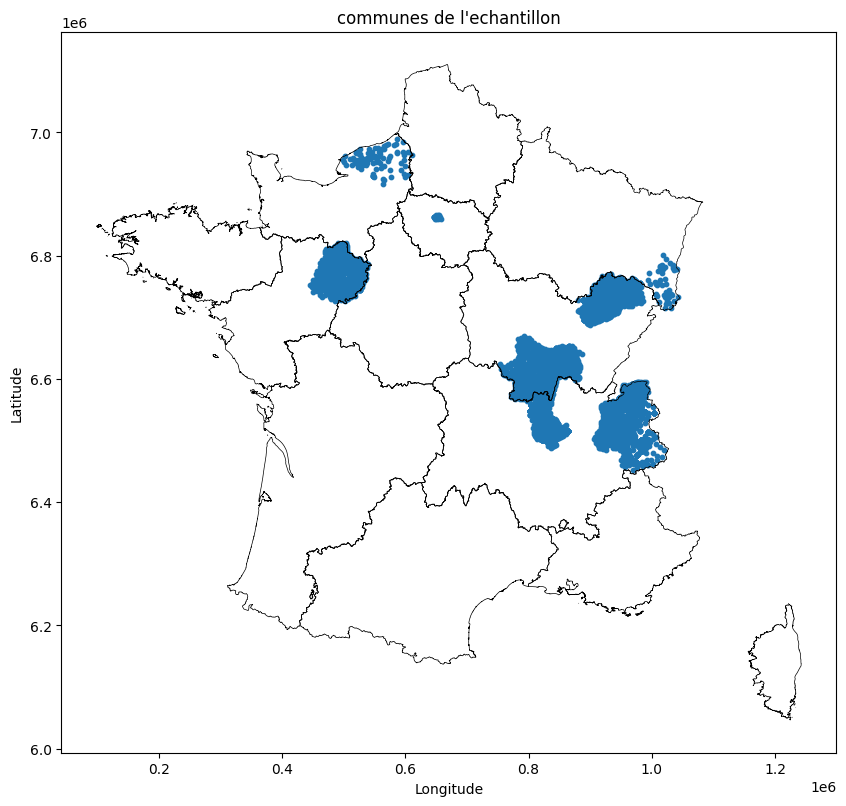

In [16]:
from cartiflette import carti_download

france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
france = france.loc[france["INSEE_REG"] > 10]
france_2154 = france.to_crs(2154)
ax1 = france_2154.boundary.plot(edgecolor="k", linewidth=0.5)
# Convertir le DataFrame pandas en GeoDataFrame avec la projection EPSG:4326

liste_commune= température[température["compteur"]==1]

geometry = [Point(xy) for xy in zip(liste_commune["longitude"], liste_commune["latitude"])]
geo_result = gpd.GeoDataFrame(liste_commune, geometry=geometry, crs="EPSG:4326")

# Reprojections des points en Lambert-93 (pour correspondre à france_2154)
geo_result_2154 = geo_result.to_crs(2154)

# Afficher la carte de la France et les communes de l'échantillon
fig, ax = plt.subplots(figsize=(10, 10))

# Afficher les frontières de la France métropolitaine
france_2154.boundary.plot(ax=ax, edgecolor="k", linewidth=0.5)



geo_result_2154.plot(ax=ax, markersize=10, legend=True)

# Afficher la carte avec les légendes
plt.title("communes de l'echantillon")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Il y a Paris, les communes de la Sarte, les communes de Savoie, de la Seine maritime, du Rhone... (Les communes sont rangées dans l'odre alphabétique des déprtements). Mais Est ce que les erreurs inacceptables sont réparties sur l'ensemble de ces communes ? 

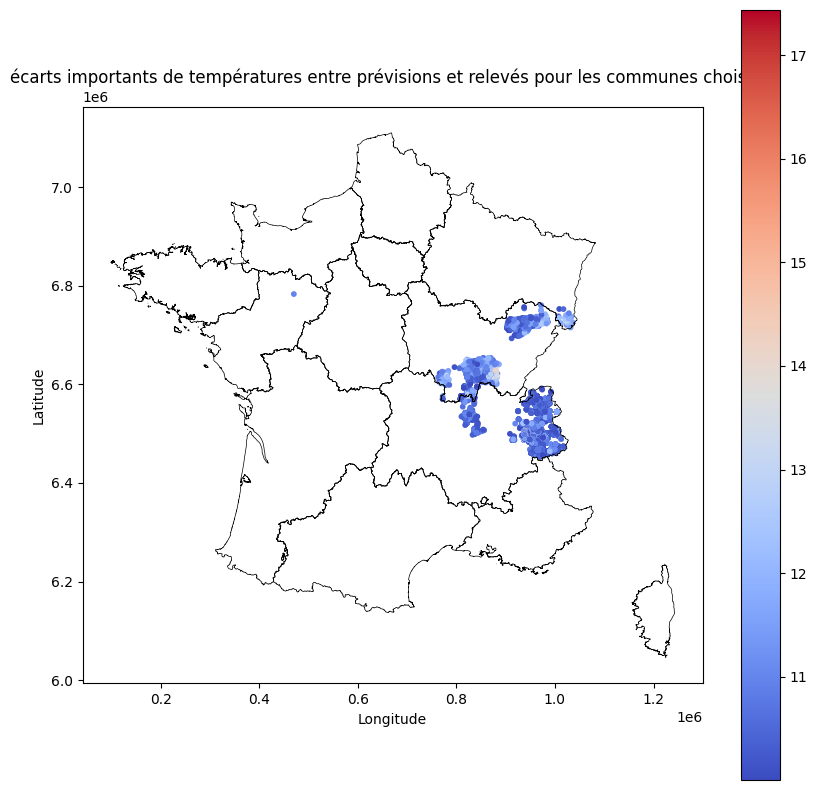

In [17]:
# on utilise le même code que précedement mais adapté pour affichier un dégrader de couleur associé aux erreurs de prédictions
geometry = [Point(xy) for xy in zip(important_error["longitude"], important_error["latitude"])]
geo_result = gpd.GeoDataFrame(important_error, geometry=geometry, crs="EPSG:4326")

geo_result_2154 = geo_result.to_crs(2154)

fig, ax = plt.subplots(figsize=(10, 10))

france_2154.boundary.plot(ax=ax, edgecolor="k", linewidth=0.5)

geo_result_2154.plot(ax=ax, column="absolute_error", cmap="coolwarm", markersize=10, legend=True)

plt.title("écarts importants de températures entre prévisions et relevés pour les communes choisies ")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

On voit ainsi que la répartition des erreurs inacceptables se situe plutot dans les régions montagneuses de l'echantillon. Pour essayer de comprendre d'où proviennent les erreurs focalisons nous sur une ville ayant de nombreuses erreurs inacceptable : 

In [18]:
#on cherche le couple de coordonnées qui reviennent les plus souvent dans le data frame qui contient l'ensemble des erreurs inacceptables 

def compte_couple(data_frame):
    dico=dict()
    for i in range(len(data_frame)):
        couple=(data_frame["latitude"].iloc[i],data_frame["longitude"].iloc[i])
        if couple in dico:
            dico[couple]+=1
        else:
            dico[couple]=1
    max_key = max(dico, key=dico.get)

    return( max_key)

compte_couple(important_error)

(np.float64(45.5274218608), np.float64(6.46078348062))

On a donc trouvé la commune avec le plus d'erreur inacceptable de l'échantillon en 2023, il s'agit de La Léchère 73260 en Savoie, Auvergne-Rhone-Alpes qui compte 2601 habitants (source : https://politique.pappers.fr/commune/lechere-73260#populationLa%20L%C3%A9ch%C3%A8re) la commune fait 134,54km² de superficie (ce qui est plus grand que Paris) et s'élève à une altitude comprise entre 411m et 2829m (Grand pic de la Lauzière ). Commencons par décrire les erreurs de prévisions que l'on observe dans cette ville, ie retrouve-t-on les mêmes résultats que précedement :  


In [19]:
#séléction de la ville 
latitude_La_Lechere = 45.5274218608
longitude_La_Lechere = 6.46078348062
tolerance = 1e-6  # Tolérance, pour éviter les problèmes d'arrondis

La_Lechere = température[
    (np.abs(température["latitude"] - latitude_La_Lechere) < tolerance) &
    (np.abs(température["longitude"] - longitude_La_Lechere) < tolerance)
]
La_Lechere=La_Lechere.drop_duplicates(subset=['date'])

In [20]:
La_Lechere

,date,temperature_2m,latitude,longitude,compteur,temperature_reelle_2m,error,absolute_error
23008140,2023-01-01 00:00:00+00:00,8.688001,45.527422,6.460783,0,6.563,2.125001,2.125001
23008146,2023-01-01 01:00:00+00:00,7.938000,45.527422,6.460783,1,6.363,1.575000,1.575000
23008152,2023-01-01 02:00:00+00:00,7.988000,45.527422,6.460783,2,5.663,2.325000,2.325000
23008158,2023-01-01 03:00:00+00:00,8.138001,45.527422,6.460783,3,5.163,2.975001,2.975001
23008164,2023-01-01 04:00:00+00:00,7.538000,45.527422,6.460783,4,4.863,2.675000,2.675000
...,...,...,...,...,...,...,...,...
23060640,2023-12-31 19:00:00+00:00,2.197000,45.527422,6.460783,8755,0.463,1.734000,1.734000
23060646,2023-12-31 20:00:00+00:00,2.197000,45.527422,6.460783,8756,0.763,1.434000,1.434000
23060652,2023-12-31 21:00:00+00:00,2.347000,45.527422,6.460783,8757,0.513,1.834000,1.834000
23060658,2023-12-31 22:00:00+00:00,2.397000,45.527422,6.460783,8758,-0.137,2.534000,2.534000


On a le même type de data frame que pour température, mais restreint à une seule commune. 

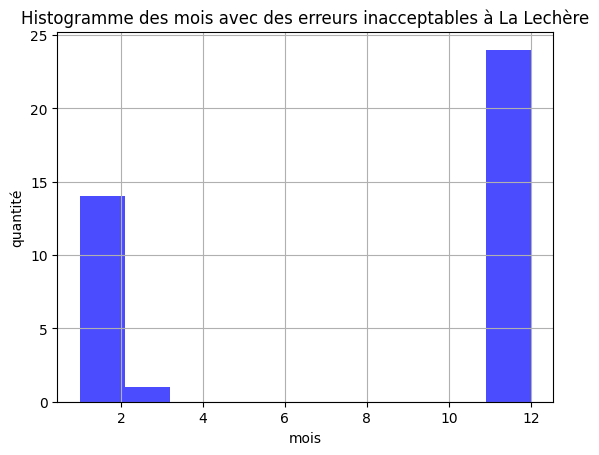

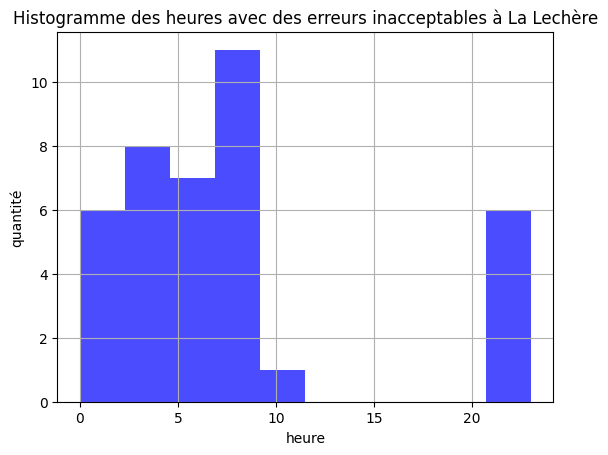

In [21]:
#on trace les histogrammes des erreurs de prédictions dans la ville, pour vois si l'on retrouve les même tendances qu'au dessus

La_Lechere_inacceptable= La_Lechere[La_Lechere["absolute_error"]>=10]

plt.hist(La_Lechere_inacceptable["date"].dt.month, alpha=0.7, color='b')

plt.xlabel('mois')
plt.ylabel('quantité')
plt.title('Histogramme des mois avec des erreurs inacceptables à La Lechère')
plt.grid(True)
plt.show()


plt.hist(La_Lechere_inacceptable["date"].dt.hour, alpha=0.7, color='b')

plt.xlabel('heure')
plt.ylabel('quantité')
plt.title('Histogramme des heures avec des erreurs inacceptables à La Lechère')
plt.grid(True)
plt.show()

On retrouve le même biais d'erreur qui semble lié au mois choisi : décembre et janvier semble les mois les moins bien prévisibles. En ce qui concerne les heures on trouve que la nuit est bien moins prédite que le reste de la journée



Focalisons nous sur 18h  : c'est l'heure ou les habitants sortent de l'école ou du travail et ont besoin de prévisions fiables

In [22]:
La_Lechere_18h = La_Lechere[La_Lechere["date"].dt.hour == 18] #étude à 18h 

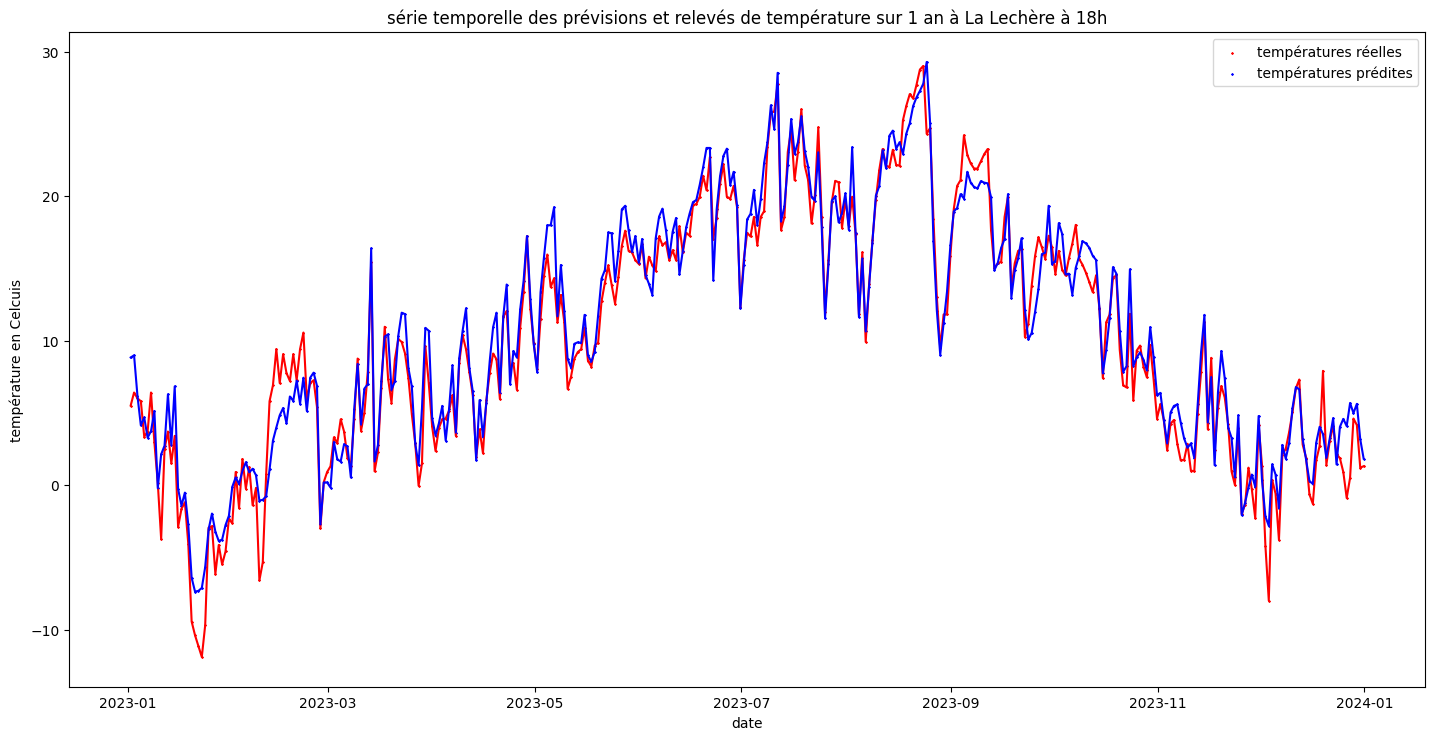

In [23]:
x = La_Lechere_18h["date"]
temperatures_reelles = La_Lechere_18h["temperature_reelle_2m"]
temperatures_predites = La_Lechere_18h["temperature_2m"]

fig = plt.figure(figsize=(17.5,8.5))

plt.scatter(x, temperatures_reelles, c='r', marker='X', s=0.5, label= "températures réelles") # température réelle 
plt.scatter(x, temperatures_predites, c='b', marker='X', s=0.5, label= "températures prédites")  # température prédite par le modèle 
plt.legend()
plt.xlabel('date')
plt.ylabel('température en Celcuis')
plt.title("série temporelle des prévisions et relevés de température sur 1 an à La Lechère à 18h")

plt.plot(x, temperatures_reelles, color='r')
plt.plot(x, temperatures_predites, color='b')

Hormis en début et fin d'année, la courbe de prédiction approxime bien la courbe des températures relevées, essayons de voir plus en détail les écarts entre ces deux courbes

<function matplotlib.pyplot.show(close=None, block=None)>

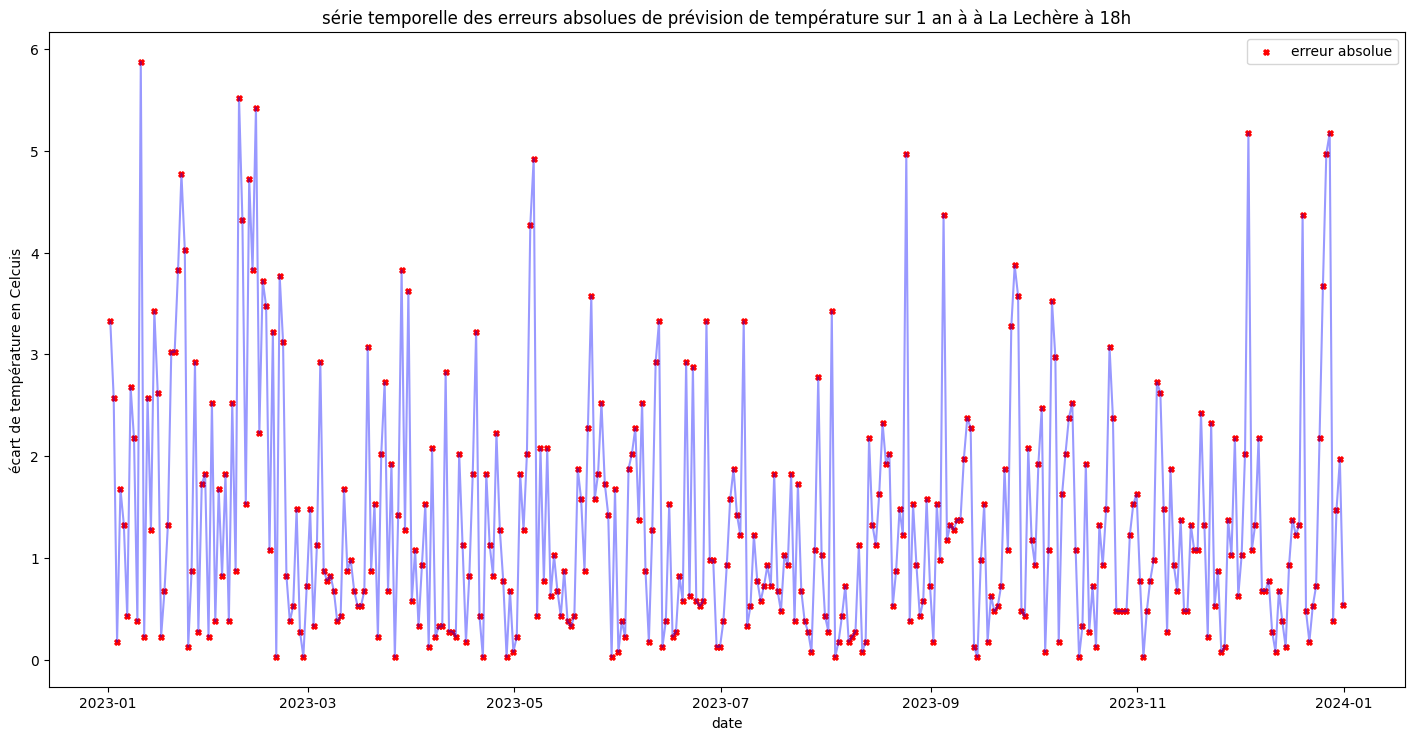

In [24]:
x = La_Lechere_18h["date"]
y1 = La_Lechere_18h["absolute_error"]


fig = plt.figure(figsize=(17.5,8.5))

# Scatter plot the points
plt.scatter(x, y1, c='r', marker='X', s=15, label= "erreur absolue") # température réelle 
plt.legend()

# Set labels
plt.xlabel('date')
plt.ylabel('écart de température en Celcuis')
plt.title("série temporelle des erreurs absolues de prévision de température sur 1 an à à La Lechère à 18h")

plt.plot(x, y1, color='b', alpha=0.4)


plt.show

A 18h le modèle semble se tromper d'au moins quelques degrés chaque jour, mais on peut mieux appricier la qualité des prédicitons d'été par rapport à celle d'hiver

II) Etude des sources d'erreurs 

Essayons de voir si la présence ou non d'autres facteurs météorologique pourraient expliquer ces écarts. En effet La Lechere est une ville de montagne, où de nombreux autres phénomènes météorologiques peuvent survenir telle que les chutes abondantes de neige etc.

In [25]:
#On requete de nouvelles données telles que les précipitations, la profondeur de la neige et la couverture nuageuse

cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude_La_Lechere,
	"longitude": longitude_La_Lechere,
	"start_date": "2023-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "precipitation", "snow_depth", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location
response = responses[0]


# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(2).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(3).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(4).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(5).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(7).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(8).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

La_Lechere_past_data = pd.DataFrame(data = hourly_data)



Il y a  5 lignes de trop dans les données historique : on les identifie puis on les retire 


In [26]:
print(La_Lechere_past_data.tail(20))
print(La_Lechere.tail(20))

                          date  temperature_2m  precipitation  snow_depth  \
8740 2023-12-31 04:00:00+00:00          -1.387            0.0        0.74   
8741 2023-12-31 05:00:00+00:00          -0.187            0.0        0.74   
8742 2023-12-31 06:00:00+00:00          -0.287            0.0        0.74   
8743 2023-12-31 07:00:00+00:00           0.063            0.0        0.73   
8744 2023-12-31 08:00:00+00:00           0.713            0.0        0.73   
8745 2023-12-31 09:00:00+00:00           2.413            0.0        0.73   
8746 2023-12-31 10:00:00+00:00           4.463            0.0        0.73   
8747 2023-12-31 11:00:00+00:00           6.413            0.0        0.73   
8748 2023-12-31 12:00:00+00:00           6.563            0.0        0.73   
8749 2023-12-31 13:00:00+00:00           5.363            0.0        0.73   
8750 2023-12-31 14:00:00+00:00           3.763            1.2        0.74   
8751 2023-12-31 15:00:00+00:00           2.313            4.9        0.74   

il y a les 5 heures manquantes dans les données prévisionnelles de 7h à 12 le 31 décembre 2023. on retire ces données du data frame historique :

In [27]:
La_Lechere_past_data['date'] = pd.to_datetime(La_Lechere_past_data['date'])

In [28]:
La_Lechere_past_data = La_Lechere_past_data.drop(La_Lechere_past_data.index[[8743,8744,8745,8746,8747]])

In [29]:
La_Lechere_past_data

,date,temperature_2m,precipitation,snow_depth,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m
0,2023-01-01 00:00:00+00:00,6.563,0.0,0.28,917.387268,26.0,24.0,33.0,0.0,7.993297
1,2023-01-01 01:00:00+00:00,6.363,0.0,0.28,917.225952,28.0,22.0,25.0,0.0,4.896530
2,2023-01-01 02:00:00+00:00,5.663,0.0,0.28,917.420593,39.0,33.0,26.0,0.0,4.610250
3,2023-01-01 03:00:00+00:00,5.163,0.0,0.28,917.775940,46.0,18.0,28.0,17.0,4.394360
4,2023-01-01 04:00:00+00:00,4.863,0.0,0.28,917.934998,42.0,40.0,31.0,0.0,4.693826
...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00+00:00,0.463,0.1,0.79,905.772034,100.0,36.0,100.0,0.0,3.600000
8756,2023-12-31 20:00:00+00:00,0.763,0.2,0.80,905.883423,96.0,2.0,96.0,0.0,3.096837
8757,2023-12-31 21:00:00+00:00,0.513,2.5,0.80,907.308594,97.0,87.0,90.0,0.0,3.976330
8758,2023-12-31 22:00:00+00:00,-0.137,0.5,0.80,908.137878,95.0,94.0,25.0,0.0,2.276840


Dans le data frame ci dessus, nous avons toujours la température réelle prise à 2m du sol, en degré. Nous ajoutons l'information sur les précipitations (en mm), la profondeur de la neige (en m), la couverture nuageuse (en %) à différentes altitudes, la pression relevée à la surface du sol (en hPa), et enfin la vitesse du vent à 10m du sol (en km/h). 

On calcul les coefficients de correlation de Pearson pour établir un lien ou non entre l'erreur absolue de prévision et d'autres facteurs météorologiques

In [30]:
x = La_Lechere["absolute_error"]
surface_pressure = La_Lechere_past_data["surface_pressure"]

corr_coeff, p_value = pearsonr(x, surface_pressure)
print(f"Coefficient de Correlation de Pearson entre l'erreur absolue et la pression de surface : {corr_coeff}")
print(f"p-value: {p_value}")

Coefficient de Correlation de Pearson entre l'erreur absolue et la pression de surface : 0.050760346065636834
p-value: 2.014769827202251e-06


In [31]:
precipitation = La_Lechere_past_data["precipitation"]

corr_coeff, p_value = pearsonr(x, precipitation)
print(f"Coefficient de Correlation de Pearsonentre l'erreur absolue et les précipations : {corr_coeff}")
print(f"p-value: {p_value}")

Coefficient de Correlation de Pearsonentre l'erreur absolue et les précipations : -0.11363474140671714
p-value: 1.4738560042453538e-26


Rien de très concluant jusque là, les coefficients de correlation sont assez faibles et les p-value sont très faibles ce qui nous indique que les liens entre ces variables sont effectivement très faibles. 

In [32]:
cloud_cover = La_Lechere_past_data["cloud_cover"]

corr_coeff, p_value = pearsonr(x, cloud_cover)
print(f"Coefficient de Correlation de Pearson entre l'erreur absolue et la couverture nuageuse : {corr_coeff}")
print(f"p-value: {p_value}")

Coefficient de Correlation de Pearson entre l'erreur absolue et la couverture nuageuse : -0.20854100932181707
p-value: 1.2575390368749227e-86


In [33]:
snow_depth = La_Lechere_past_data["snow_depth"]

corr_coeff, p_value = pearsonr(x, snow_depth)
print(f"Coefficient de Correlation de Pearson entre l'erreur absolue et la profondeur de la neige : {corr_coeff}")
print(f"p-value: {p_value}")

Coefficient de Correlation de Pearson entre l'erreur absolue et la profondeur de la neige : 0.2850548533967957
p-value: 2.4865830857327962e-163


Pour l'épaisseur de neige et la couverture nuageuse, on obtient de meilleurs coefficient de correlation, avec des p-value extremement faible : 0.29 et -0.20 respectivement pour les coefficients de correlation. Les erreurs de prévisions seraient donc un peu corrélées à la présence de neige sur le sol, étudions cela plus en détail. 

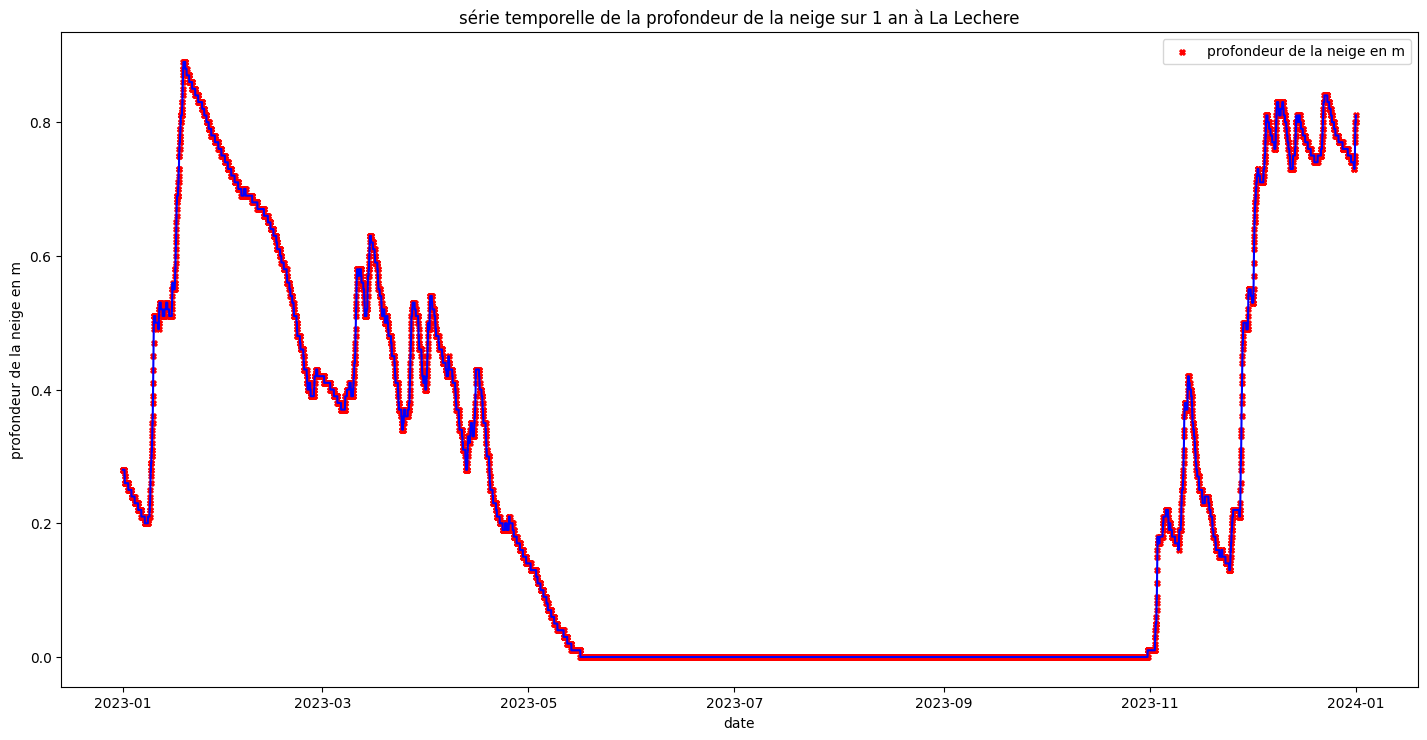

In [34]:
La_Lechere_past_data['date'] = pd.to_datetime(La_Lechere_past_data['date'])
x = La_Lechere_past_data["date"]
y1 = La_Lechere_past_data["snow_depth"]


fig = plt.figure(figsize=(17.5,8.5))

# Scatter plot the points
plt.scatter(x, y1, c='r', marker='X', s=15, label= "profondeur de la neige en m")  
plt.legend()

# Set labels
plt.xlabel('date')
plt.ylabel('profondeur de la neige en m')
plt.title("série temporelle de la profondeur de la neige sur 1 an à La Lechere")

plt.plot(x, y1, color='b')

Cepedant, comme ce graphique nous le rappel, il n'y a pas de neige l'été ! mais quand même des erreurs de prévisions ! Superposons ce courbes pour mieux voir, en retirant les valeurs lors de la fin du printemps, de l'été et du début de l'automne (par continuité du tracé une ligne horizontale apparait, il ne faut pas en tenir compte).

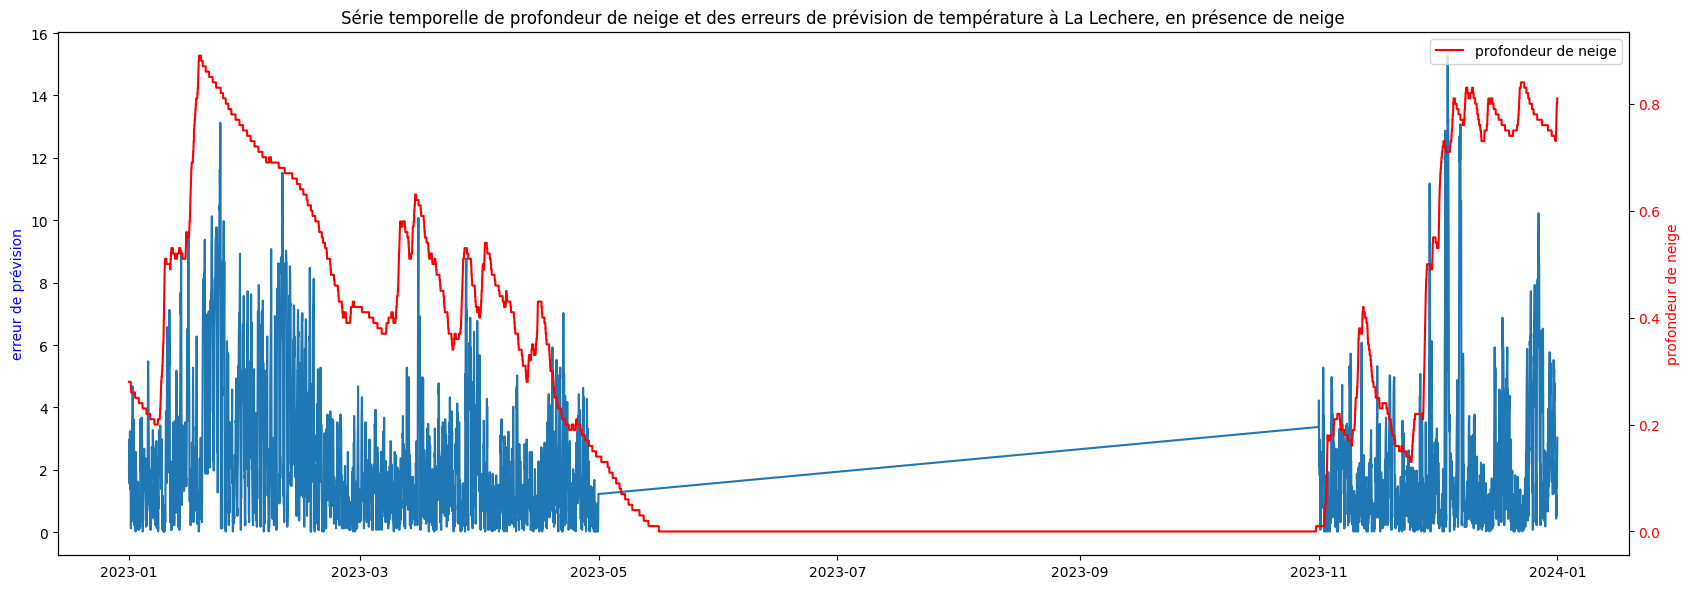

In [46]:
La_Lechere_past_data['date'] = pd.to_datetime(La_Lechere_past_data['date'])
x = La_Lechere_past_data["date"]
y1 = La_Lechere_past_data["snow_depth"]


fig, ax1 = plt.subplots(figsize=(17, 6))
plt.title('Série temporelle de profondeur de neige et des erreurs de prévision de température à La Lechere, en présence de neige')


dates = La_Lechere_past_data["date"]
values = np.array(La_Lechere["absolute_error"])
df = pd.DataFrame({'value': values}, index=dates)


month_without_snow = [5,6, 7, 8,9,10]  #mai, juin, juillet, aout, septembre et octobre

# Création d'un Booléen pour les mois avec ou sans neige
no_snow = ~df.index.month.isin(month_without_snow)


ax1.plot(df.index[no_snow], df['value'][no_snow])
ax1.plot(df.index[~no_snow], df['value'][~no_snow],linestyle='', alpha = 0.001) 
ax1.set_ylabel('erreur de prévision', color='b')


# Création d'un second axe d'ordonné pour plus de lisibilité
ax2 = ax1.twinx()


ax2.plot(x, y1, 'r-', label='profondeur de neige')
ax2.set_ylabel('profondeur de neige', color='r') 
ax2.tick_params(axis='y', labelcolor='r') 


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")


fig.tight_layout()


plt.show()



les variations de profondeur de neige semblent en hiver mieux expliquer la présence d'erreurs de prévisions. Mais est ce que retirer les d'été valeurs améliore réellement la corrélation entre ces variables ? 

In [36]:
dates = La_Lechere_past_data["date"]
values_error = np.array(La_Lechere["absolute_error"])
values_snow = np.array(La_Lechere_past_data["snow_depth"])

df = pd.DataFrame({'value_snow': values_snow, 'value_error' : values_error}, index=dates)

summer_months = [5,6, 7, 8,9,10] 
not_summer = ~df.index.month.isin(summer_months)
df_2 = df[not_summer]

snow_depth_winter_only = df_2["value_snow"]
date_only_winter = df_2["value_error"]

corr_coeff, p_value = pearsonr(date_only_winter, snow_depth_winter_only)
print(f"Pearson Correlation Coefficient entre l'erreur absolue et la profondeur de la neige en hiver: {corr_coeff}")
print(f"p-value: {p_value}")




Pearson Correlation Coefficient entre l'erreur absolue et la profondeur de la neige en hiver: 0.3180030581763714
p-value: 1.4995108742685257e-102


Le coefficient de corrélation augmente légèrement, mais cela ne semble pas être concluant. Ainsi l'ajout d'information via de nouvelles variables météorologiques ne nous aide pas à mieux comprendre d'où proviennent les erreurs de prédiction de température. 

III) Prédiction sur les prévisions 

Essayons à présent de prédire la température réelle à partir de la prévision faire par météo France.
Commençons par approximer par une fonction polynomiale l'ensemble de nos données, puis nous utiliserons un algorithme de random forest pour prédire la température réelle à une heure donnée à partir de la prédiction initiale effectuée par météo France

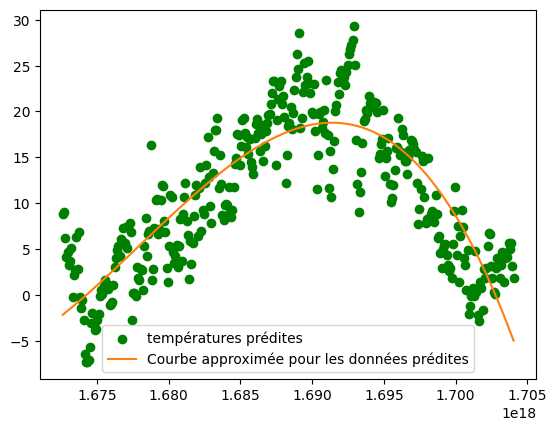

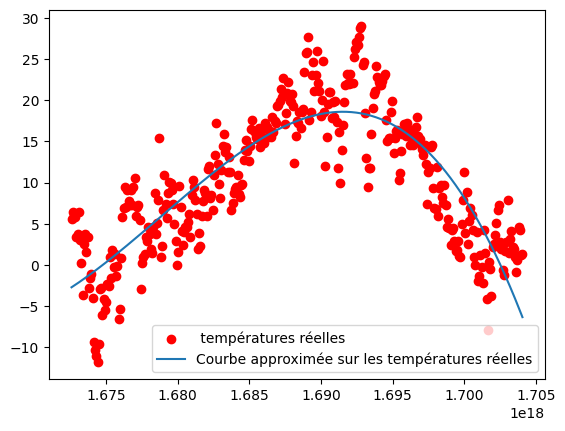

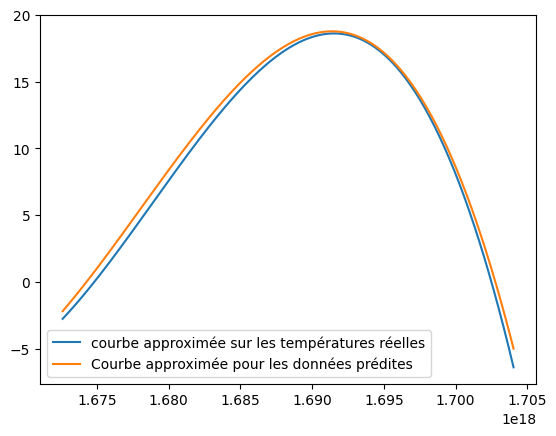

In [37]:
time = La_Lechere_18h["date"].values.astype(float) # on doit convertir les date en nombre 
real_values = La_Lechere_18h["temperature_reelle_2m"].values
values=La_Lechere_18h["temperature_2m"].values

def polynomial(x, a, b, c, d):
    return a * x**4 + b * x**3 + c*x**2 + d*x 


# Fit the curve
popt, pcov = curve_fit(polynomial, time, values )
plt.scatter(time, values, label='températures prédites', c="g")
plt.plot(time, polynomial(time, *popt), label='Courbe approximée pour les données prédites', c="C1")
plt.legend()
plt.show()

popt1, pcov1 = curve_fit(polynomial, time, real_values )
plt.scatter(time, real_values, label=' températures réelles' , c="r")
plt.plot(time, polynomial(time, *popt1), label='Courbe approximée sur les températures réelles')
plt.legend()
plt.show()

#superposision des deux corubes précédentes pour apprécier les écarts entre celles ci
plt.plot(time, polynomial(time, *popt1), label='courbe approximée sur les températures réelles')
plt.plot(time, polynomial(time, *popt), label='Courbe approximée pour les données prédites')
plt.legend()
plt.show()


Avec le curve fitting des données on retrouve bien l'accentuation des écarts de températures entre prédictions et réalité en hiver : les températures réelles sont ici approché par un polynome dont les ordonnées sont plus faible que celles du polynome pour les valeurs prédites. 

Utilisons désormais un algorithme de Random Forest pour prédire la température réelle à La Lechere en fonction de la température prévue par Météo France.L'algorithme de random forest est ici utilisé comme un filtre correcteur des prévisions de météo France.

Préparations des jeux de données d'entrainement et de test, nous évaluons ensuite le modèle avec le calcul du R2

In [38]:
dates = La_Lechere["date"]
temperatures_reelles_La_Lechere = np.array(La_Lechere["temperature_reelle_2m"])
temperatures_predites_La_Lechere = np.array(La_Lechere["temperature_2m"])
df = pd.DataFrame({'real_temp': temperatures_reelles_La_Lechere, 'prediction': temperatures_predites_La_Lechere}, index=dates)


X = df[['prediction']]  
y = df['real_temp']     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)

rf_model = RandomForestRegressor(n_estimators=200, random_state=100, max_depth=7) #j'ai mis un peu aléatoirement je le reconnais
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R²: {r2}")



Mean Squared Error: 5.341984660683371
R²: 0.9313998129344234


Nous avons un R² très proche de 1, signe d'un modèle bien entrainé ! 

On va maintenant essayer le modèle avec de nouvelles données pour cela on requete encore une fois auprès de open-meteo, toujours dans la ville de La Lechere, mais pour l'année 2024.

In [39]:
#températures prédites par météo France

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": latitude_La_Lechere,
	"longitude": longitude_La_Lechere,
	"start_date": "2024-01-01",
	"end_date": "2024-12-25",
	"hourly": "temperature_2m",
	"models": "meteofrance_seamless"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m

prevision_noel_la_lechere= pd.DataFrame(data = hourly_data)


In [40]:
#températures réelles

cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude_La_Lechere,
	"longitude": longitude_La_Lechere,
	"start_date": "2024-01-01",
	"end_date": "2024-12-25",
	"hourly": "temperature_2m"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m_reelle"] = hourly_temperature_2m

temperature_reelle_noel_la_lechere = pd.DataFrame(data = hourly_data)


Applications du modèles aux nouvelles données ie on applique le modèles au prévisions de températures par heure de l'année 2024 (jusqu'au 25 décembre), que l'on va confronter avec les températures effectivement relevées

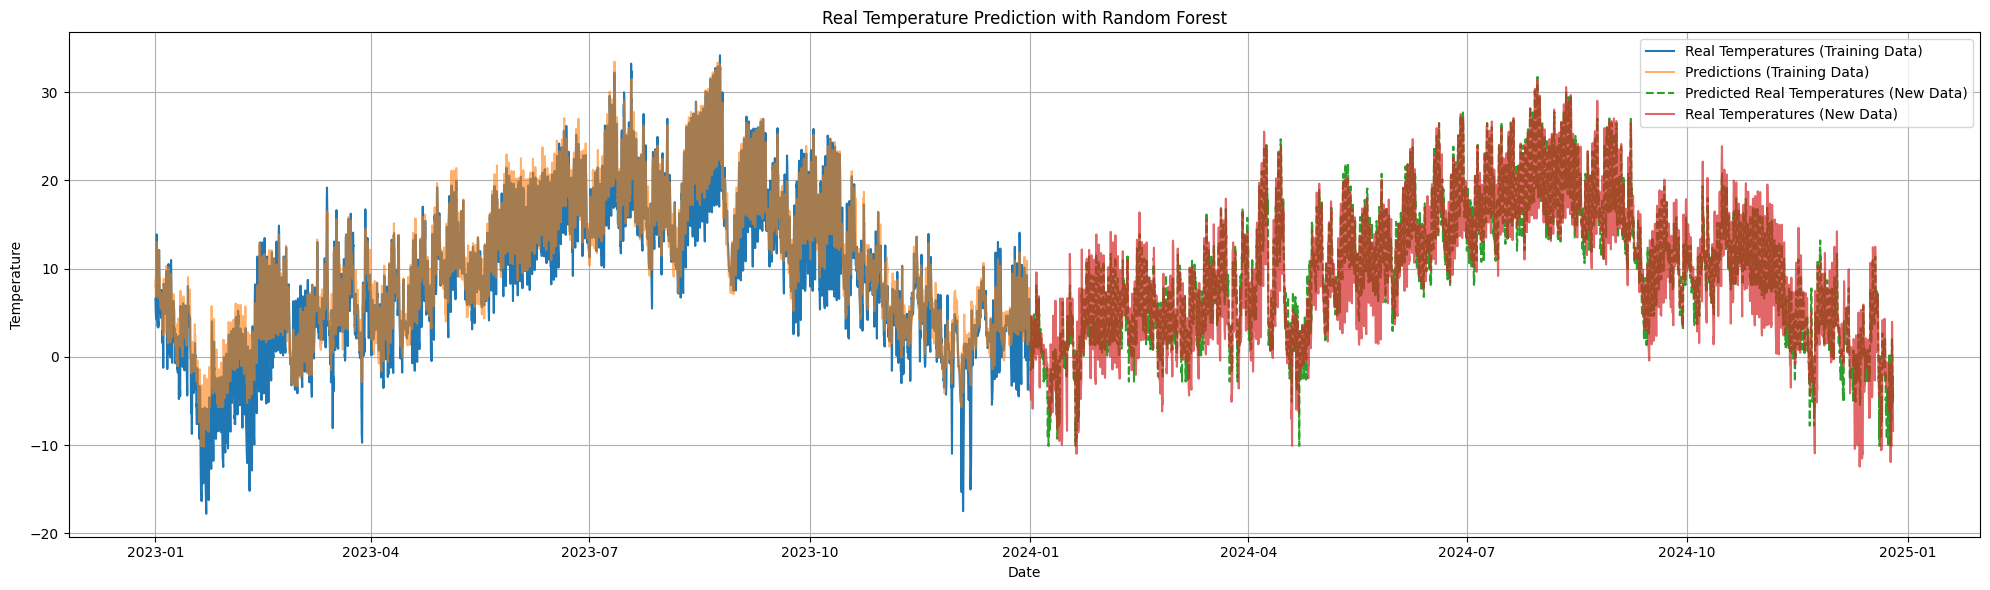

In [41]:
new_dates = temperature_reelle_noel_la_lechere["date"] # nous sommes désormais en 2024
new_predictions = np.array(prevision_noel_la_lechere["temperature_2m"]) # prévisions pour chaque heure de la température en 2024 
new_real_temp = np.array(temperature_reelle_noel_la_lechere["temperature_2m_reelle"]) #températures réelles par ehure à La Lechère en 2024

new_df = pd.DataFrame({'prediction': new_predictions}, index=new_dates)  # création des data frame qui ne contiennet que les données qui nous interessent
new_df_real = pd.DataFrame({'real_temp' :new_real_temp}, index= new_dates)
new_X = new_df[['prediction']]
new_real_temps_predicted = rf_model.predict(new_X) #application du modèle aux températures prévues

new_df['predicted_real_temp'] = new_real_temps_predicted #températures réelles prévues par le modèle de random forest

#on trace tou ca : On trace les deux années de données 
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['real_temp'], label='Real Temperatures (Training Data)')
plt.plot(df.index, df['prediction'], label='Predictions (Training Data)', alpha=0.6)
plt.plot(new_df.index, new_df['predicted_real_temp'], label='Predicted Real Temperatures (New Data)', linestyle='--')
plt.plot(new_df.index, new_df_real['real_temp'],label = 'Real Temperatures (New Data)', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Real Temperature Prediction with Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Lecture : à Gauche se trouve les données d'entrainement année 2023 et à droites de nouvelles données (2024) sur lesquelles on a appliqué la prédiction par random forest, ce graphique est assez joli, mais ne permet pas in fine d'évaluer le modèle sur les données de 2024

Ajoutons la température réelle au new_df, pour pouvoir comparer la prévision de météo france et la modification de la prévision par le modèle de random forest. ie on souhaite obtenir une moyenne d'erreur plus faible après le traitement des données par l'algo de random forest. Est-ce bien le cas ? 

In [42]:
new_df["temperature_2m_reelle"] = np.array(temperature_reelle_noel_la_lechere["temperature_2m_reelle"])
new_df["absolute_error of the random forest"]=abs(new_df["predicted_real_temp"]-new_df["temperature_2m_reelle"])
new_df["absolute_error of meteo  france"]=abs(new_df["prediction"]-new_df["temperature_2m_reelle"])
new_df["error_of meteo_france"]= new_df["prediction"]-new_df["temperature_2m_reelle"]
new_df["error_of_random_forest"]=new_df["predicted_real_temp"]-new_df["temperature_2m_reelle"]
new_df.describe()

,prediction,predicted_real_temp,temperature_2m_reelle,absolute_error of the random forest,absolute_error of meteo france,error_of meteo_france,error_of_random_forest
count,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000
mean,10.637944,9.560490,9.258208,1.774917,1.966894,1.379736,0.302281
std,7.116212,7.489572,7.872705,1.511202,1.807782,2.287642,2.311502
min,-5.112000,-10.104177,-12.436999,0.000360,0.024999,-6.974998,-8.567177
25%,4.938000,3.779880,3.313000,0.666543,0.625000,-0.175000,-1.246998
50%,10.338000,9.671196,8.863000,1.407050,1.474998,1.075000,0.097275
75%,15.838000,15.129961,15.013000,2.477236,2.725000,2.575000,1.611170
max,31.487999,31.707171,31.313000,12.147915,13.275000,13.275000,12.147915


Le modèle de Random forest s'est en moyenne trompé de 1.77°C, tandis que la moyenne d'erreur initiale est de 1.97°C, aisni en moyenne à La lechere sur l'année 2024, l'algorithme de random forest a premis de réduire l'erreur absolue de prévision de température de 0.2°C... c'est peu regardons la distribution des erreurs : 

C:\Users\tsang\AppData\Local\Temp\ipykernel_10716\755534140.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df['error_of meteo_france'],label='erreur de météo france', color='blue')
C:\Users\tsang\AppData\Local\Temp\ipykernel_10716\755534140.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dis

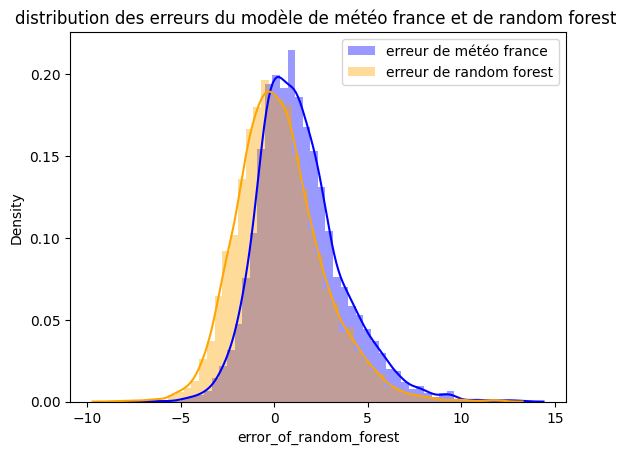

In [43]:
#environ 1m30s à executer

plt.figure()
sns.distplot(new_df['error_of meteo_france'],label='erreur de météo france', color='blue')
plt.title("distribution des erreurs du modèle de météo france et de random forest ")
sns.distplot(new_df['error_of_random_forest'],label='erreur de random forest', color='orange')
plt.legend()
plt.show()

Le modèle de random forest prédit donc des températures inférieures au températures réelles, tandis que le modèle de météo france prédit des températures plus élevées. Ainsi l'algorithme de random forest anticipe trop l'erreur de prévision de météo france et la corrige trop, ce qui le pousse à se tromper lui aussi

C:\Users\tsang\AppData\Local\Temp\ipykernel_10716\608874186.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df['absolute_error of meteo  france'],label='erreur absolue de météo france', color='blue')
C:\Users\tsang\AppData\Local\Temp\ipykernel_10716\608874186.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750

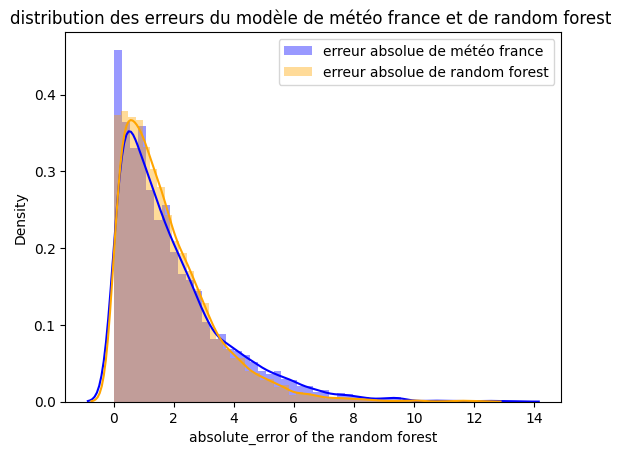

In [44]:
plt.figure()
sns.distplot(new_df['absolute_error of meteo  france'],label='erreur absolue de météo france', color='blue')
plt.title("distribution des erreurs du modèle de météo france et de random forest ")
sns.distplot(new_df['absolute_error of the random forest'],label='erreur absolue de random forest', color='orange')
plt.legend()
plt.show()

Lorsque l'on regarde la distribution des erreurs absolues, on voit bien que l'algorithme de random forest atténue foretment les grosses erreurs de prédiction,  ce qui lui permet de faire moins de grandes erreurs mais comme il corrige trop les petites erreurs aussi, cela le conduit à faire une erreur de signe opposé à celle de météo france. 

Le modèle de random forest a ainsi tendance à faire plus de petites erreurs de prédictions que le modèle de météo france, mais à faire mois d'erreurs dites inacceptables. 
Il est toutefois important de rappelé que l'algorithme de random forest utilise lui même les données de prédictions, ainsi il est très dépendant de la qualité même des prévisions initialement effectuées ! 



Pour conclure sur cette partie de prédiction : une meilleure compréhension des algorithme de prédiction et ici de l'algorithme de random forest premmettrait une meilleure comprhéensio des parmètres et donc dee réduire l'erreur effectuée par le modèle de random forest. 